## Practical Phase Field With Examples

Dan Lewis  
Rensselaer Polytechnic Institute  
lewisd2@rpi.edu

## Outline

This presentation covers three essential models that provide the basis for phase field modeling:

1.  A Pure Material
1.  Spinodal Decomposition (and Order Disorder Transformations)
1.  Multi-Order Parameter Models

##  Getting Started

To use these notes you will need:

* A Python installation (such as Anaconda)
* The FiPy PDE solving package (installed via Python commands)
* The ability to start and use basic functionality of the Jupyter Notebook 
* An understanding of basic numerical methods

## References

* W. J. Boettinger, J. A. Warren, et al., "Phase Field Simulation of Solidification", Annual Review of Materials Research, v32, p163-194 (2002)
* Free Energy of a Nonuniform System. I. Interfacial Free Energy, Journal of chemical Physics, v28, n2, p258-267 (1958) 
* R. DeHoff, "Thermodynamics in Materials Science", CRC Press, 2006
* FiPy at http://www.nist.gov

## Introduction
----

* The phase field method makes possible the study of complex microstructural morphologies such as dendritic and eutectic solidification as well as polycrystalline growth.  
* The major contribution of the method is the introduction of an order parameter used to delineate phases such as solid/liquid, $\alpha~/~\beta$, etc.  The concept of an order parameter is not new.  However, smoothly varying this order parameter through an interphase interface frees us from tracking the interface position and applying boundary conditions at interfaces having complex morphologies.
* Three "building block" models are important for study, 1) the pure material, 2) a chemical solution model, and 3) a multiphase model.  These three models are the basis for other complex models.

A small excerpt from Boettinger's review paper (cited above):

>The method employs a phase-field variable, e.g., $\phi$, which is a function of position and time, to describe whether the material is liquid or solid. The behavior of this variable is governed by an equation that is coupled to equations for heat
and solute transport. Interfaces between liquid and solid are described by smooth but highly localized changes of this variable between fixed values that represent solid and liquid, (in this review, 0 and 1, respectively).

Using the order parameter in this way makes it easier to calculate solidification microstructures - we no longer have to track the interface.  The shape (while changing from 0 to 1) of this interface is a balance between two forces.  The energy increase for intermediate states between solid and liquid (from the bulk free energy) and energy costs associated with steep gradients in the phase-field order parameter.

## The Free Energy of a Non-Uniform System
----

Cahn and Hilliard identified the lowest order correction to the free energy density that arises from the presence of an interface.  Inclusion of this term forms the energetic basis for the phase-field method.

If the temperature and pressure are our process variables, then we can use the Gibbs free energy.  The total energy of the system is found by integrating the Gibbs free energy density over the volume of the system.  Furthermore we assume that the order parameter (and/or composition) and powers of the derivatives of order parameter all contribute to the free energy and are independent:

$$
\mathscr{F} = \int_V f_v(\phi, \nabla \phi, \nabla^2 \phi, ...) \delta V
$$

It is possible to expand the integrand explicitly in powers of the independent parameters (a multivariate Taylor series), in a shorthand notation we write an equivalent statement:

$$
f_v = f_v^0 + L \nabla \phi + K_1 \nabla^2 \phi + K_2 (\nabla \phi)^2 + \; ...
$$

with

$$
L = \left( \frac{\partial f_v}{\partial (\nabla \phi)} \right)
$$

and **other similar terms** as per the Taylor's Series expansion above treating $\phi$ and all higher order derivatives as independent parameters in the free energy space.  These extra terms can be viewed as "correction" terms in the approximation of the free energy density near equilibrium.

Other terms are argued to be zero due to symmetry considerations.

We keep the lowest order, nonzero correction term in the gradient of the concentration.  These assumptions can be relaxed for different applications.  Once the bulk free energy, $f_v$, is identified it is possible to find the function $\phi(x)$ that makes the integral an extreme value.  The functional is therefore composed of two parts, a bulk energy and a gradient energy:

$$
\mathscr{L} = \int_V \mathscr{F}(\phi, \nabla \phi)\; \delta V = \int_V f_v(\phi, T) + K (\nabla \phi)^2 \; \delta V
$$

We can do this analytically for a pure material, but most other applications require relaxation/numerical methods.

## A Homogeneous Free Energy Function
----

It is necessary to have a smooth function that links the order parameter to other thermodynamic variables such as temperature or composition.  There are two so-called helper functions that help the modeler homogenize the free energy.  The interpolating function, $p(\phi)$ and the double well function $g(\phi)$ are used for this purpose.  For reference they are plotted below.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

def plot_p_and_g():
    phi = np.linspace(-0.1, 1.1, 200)
    g=phi**2*(1-phi)**2
    p=phi**3*(6*phi**2-15*phi+10)

    # Changed 3 to 1 in the figure call.
    plt.figure(1, figsize=(10,5))
    plt.subplot(121)
    plt.plot(phi, g, linewidth=1.0);
    plt.xlabel('$\phi$', fontsize=12)
    plt.ylabel('$g(\phi)$', fontsize=12)

    plt.subplot(122)
    plt.plot(phi, p, linewidth=1.0);
    plt.xlabel('$\phi$', fontsize=12)
    plt.ylabel('$p(\phi)$', fontsize=12)
    
    return

<IPython.core.display.Javascript object>


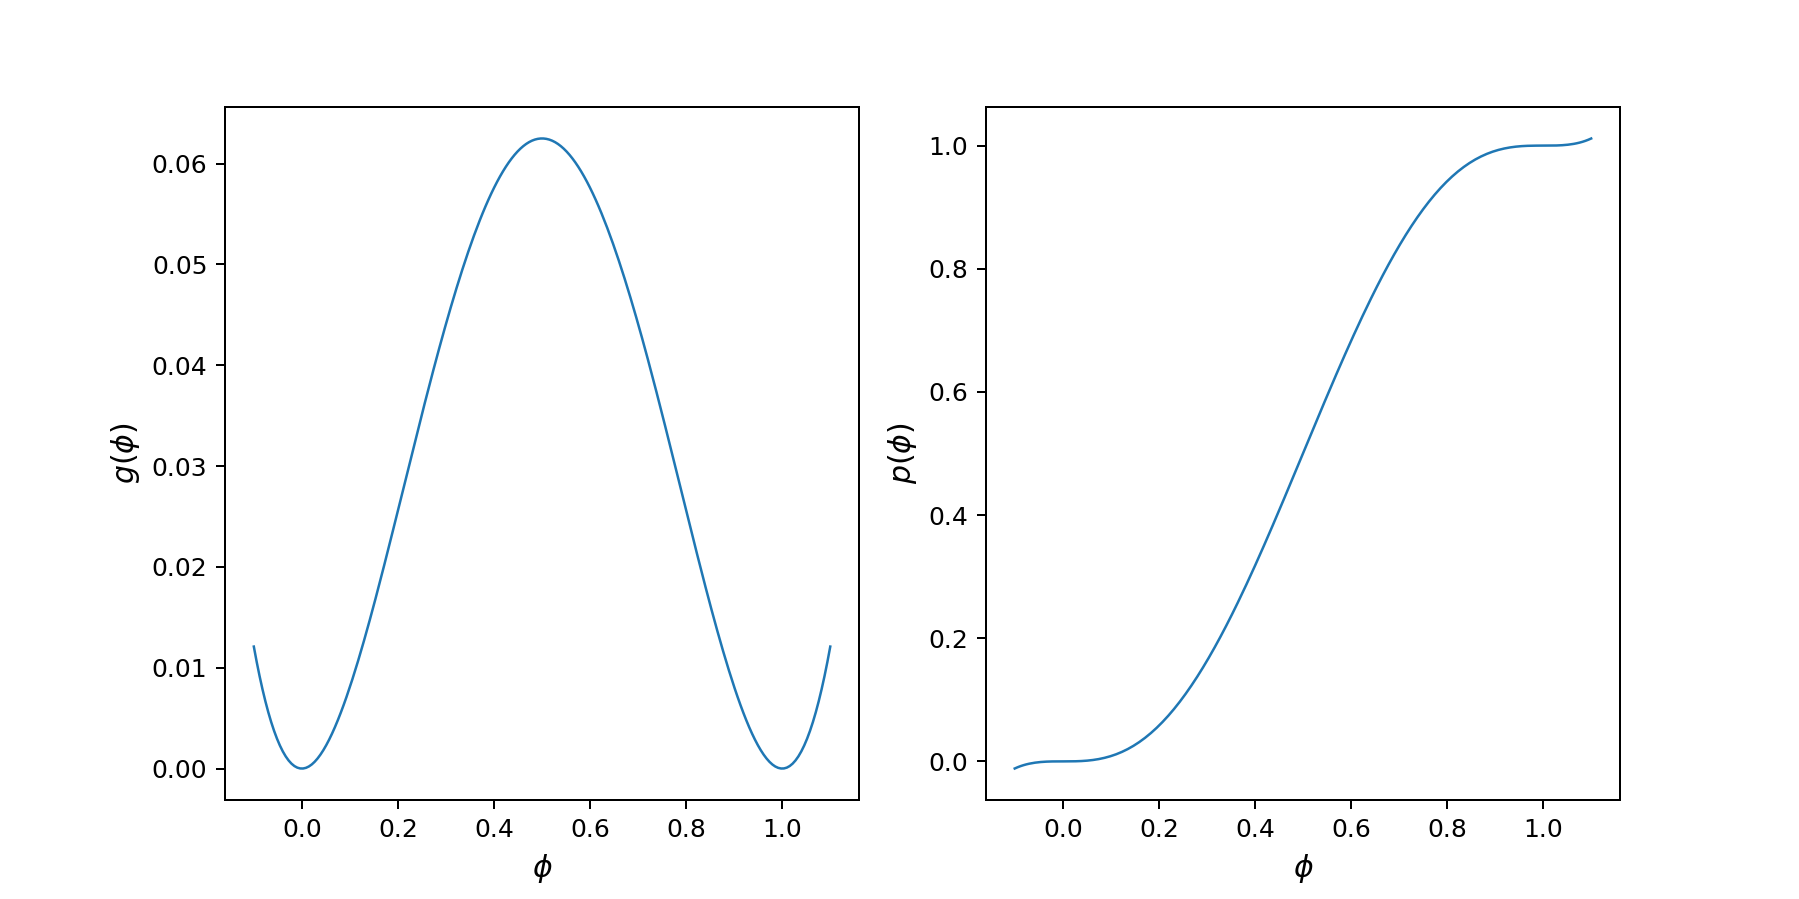

In [4]:
plot_p_and_g()

## Example 1A: Pure Material
----


Using the Lagrangian with the squared gradient correction and the helper functions we are ready to construct the free energy of a pure system.  We start by using the ordinary free energy of the pure components:

 * Pure A, liquid phase - $f_A^L(T)$
 * Pure A, solid phase - $f_A^S(T)$

As we will be limiting ourselves to a pure material at this time, these are the only two free energies we need.  Near the melting point these free energies are often modeled as straight lines using the relationship for the Gibbs free energy:

$$G = H - TS$$

taking H and S to be constants.  Following conventions of the phase diagram modeling community we take the reference state of the component A to be the equilibrium phase at STP.  If this were a metal like Cu then the reference state would be the FCC phase.  For us, that will be the SOLID.  This sets:

$$f_A^S(T) = 0$$

Expanding the difference in free energy between the solid and the liquid around the melting point results in:

$$f_A^L(T)-f_A^S(T) = L_A \frac{(T_M^A - T)}{T_M^A}$$

The next step is to homogenize the free energy for component A.  We build the free energy $f(\phi,T)_A$ as follows:

$$f(\phi,T)_A = W_A~g(\phi) + f_L p(\phi) + f_S (1-p(\phi))$$

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_homogeneous_F():
    plt.fig = plt.figure(2, figsize=(5,5))
    plt.ax = plt.fig.gca(projection='3d')

    phi = np.linspace(0.0, 1.0, 100)
    temperature = np.linspace(0.0, 1.0, 100)
    phi,temperature = np.meshgrid(phi,temperature)

    W=30.0
    L=1.0
    Tm=0.5
    g=phi**2*(1-phi)**2
    p=phi**3*(6*phi**2-15*phi+10)

    f = W*g+L*p*(Tm-temperature)/Tm

    energyPlot = plt.ax.plot_surface(phi, temperature, f, label=None, 
                    cmap=plt.cm.coolwarm, rstride=5, cstride=5, alpha=0.5)
    energyPlot = plt.contour(phi, temperature, f, 20)

    plt.clabel(energyPlot, inline=1, fontsize=10)
    plt.ax.set_xlabel('$\phi$')
    plt.ax.set_ylabel('T')
    plt.ax.set_zlabel('$f(\phi,t)$')
    
    return

so that:

$$f(\phi,T)_A = W_A~g(\phi) + L_A \frac{(T_M^A - T)}{T_M^A}p(\phi)$$

Plotting this and viewing the results from different angles will help us see how more traditional treatments are embedded within a continuous energy space.

In [ ]:
plot_homogeneous_F()

## The Analytic Solution
----

If we are at the melting temperature, the temeprature dependent term goes to zero and we are left with:

$$
F(\phi,\phi') = W \phi^2 (1-\phi)^2 + \epsilon (\nabla \phi)^2
$$

Applying the Euler-Lagrange equation to our functional we get:

\begin{align}
\frac{\delta F}{\delta \phi} & = \frac{\partial F}{\partial \phi} - \frac{d}{dx} \frac{\partial F}{\partial \nabla \phi} = 0 \\ &= 2 W \phi \left(\phi - 1\right) \left(2 \phi - 1\right) - 2 \epsilon \nabla^2  \phi = 0
\end{align}

recall that $\phi(x,t)$ and this equation implies equilibrium.

There is a fair bit of algebra and a few assumptions that enable the solution to the Euler-Lagrange equation above:

* First - assume that you are at the melting temperature.  The rationale is that this is the only temperature where BOTH phases CO-EXIST.  Any other temperature and it does not make sense to discuss an interface.  This removes the second term on the RHS of the above expression.
* Second - you can use $\frac{d\phi}{dx}$ as an integrating factor to take the first integral of the Euler-Lagrange equation.
* Third - after evaluating the constant (C=0 is the answer) the equation is seperable and can be integrated.
 
The result is:
 
$$\phi(x) = \frac{1}{2} \Big[ 1 + \tanh \Big( \frac{x}{2\delta} \Big) \Big]$$
 
where $\delta$ (the interface thickness) is related to the $W$ and $\epsilon$ parameters and can also be related to $\gamma$ (the surface energy). 

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, fixed

fig = None
def plot_equilibrium(W=500.0, epsilon=1.0):
    global fig
    if fig: plt.close(fig)
    fig = plt.figure()
    x = np.linspace(-1.0, 1.0, 200)
    phi = 0.5*(1+np.tanh(x*np.sqrt(2*W)/(2*epsilon)))
    plt.plot(x, phi, linewidth=1.0)
    plt.xlabel('$x$', fontsize=12)
    plt.ylabel('$\phi(x)$', fontsize=12)    
    plt.show()
    return

In [ ]:
interact(plot_equilibrium, W=(0.001,1000,10), epsilon=fixed(1.0));

## Takeaways
----

* The pure material illustrates how the thermodynamics relates to the order parameter.
* The analytical solution illustrates more clearly the $W$ and $\epsilon$ parameters in terms of the interface shape, from this we can precisely compute the excess Gibbs energy due to the interface (the surface energy) and the interface thickness.
* Analytic solutions are not available (and likely not possible) for the alloy or more complicated cases.  A relaxation method is used, instead.


## Solving the PDE Using Relaxation
----

With the bulk free energy and the gradient energy contributions conceptually justified it is now necessary to identify the equations of motion.  In the non conserved case:

$$
\frac{\partial \phi}{\partial t} = -M \frac{\delta F}{\delta \phi}
$$

and for a conserved order parameter the equations of motion are derived from:

$$
\frac{\partial \phi}{\partial t} = \nabla \cdot D \nabla \frac{\delta F}{\delta \phi}
$$

There are other choices, but these are the simplest choices that guarantee a free energy decrease with time.

For this demonstration, FiPy will be used to solve the phase field equations.  FiPy is a vinite volume PDE solver that provides access to _diffusion_, _convection_, and _source_ terms that would be present in a typical phase field PDE.  FiPy has much more functionality then what is shown here.  

FiPy is imported along with some helper functions.  This example is for a NON-conserved order parameter.

In [ ]:
%matplotlib notebook
from fipy import *
from IPython.display import clear_output

The parameters that define our mesh are set.

In [ ]:
L = 1.
nx = 400
dx = L/nx

We use FiPy's Grid1D method to produce a mesh and place our phase variable on that mesh.

In [ ]:
mesh = Grid1D(dx=dx, nx=nx)
phase = CellVariable(name="phase",mesh=mesh)

Getting the centerpoint of each cell permits us to write geometric constraints for setting the intital conditions, etc.

In [ ]:
x = mesh.cellCenters
phase.setValue(1.)
phase.setValue(0., where=x > L/2)

FiPy has built in viewers for observing the results.

In [ ]:
viewer = MatplotlibViewer(vars=(phase,),datamin=-0.1, datamax=1.1, legend=None)

We set the remaining simulation parameters, such as the gradient energy coefficient, the double well potential, and the thermodynamic parameters.  Note the addition of the mobility $M$ for the relaxation method.  This term can be physically correlated to the atomic attachment kinetcs.

In [ ]:
eps_sqrd = 0.00025 
M = 1.0
W = 0.5
Lv = 1.
Tm = 1.
T = 1.0
enthalpy = Lv*(Tm-T)/Tm

The final step to setup the problem is to partition our model into FiPy's terms.  In this case we have a single diffusion term.  We bundle all the remaining terms into the source term:

In [ ]:
S0 = W*2.0*phase*(phase-1.0)*(2*phase-1.0) + 30*phase**2*(phase**2-2*phase+1)*enthalpy
eq = TransientTerm() == DiffusionTerm(coeff=eps_sqrd*M) - S0

FiPy has many solvers, we use the default solvers and call for the solution to the equations.

In [ ]:
for i in range(50):
    eq.solve(var = phase, dt=0.1)
    viewer.plot()
    clear_output(wait=True)
    display(viewer)

## Example 1B:  Pair of Particles
----

The Gibbs-Thomson effect is present within the energy formulation of the phase field equations.  Because of this, curved particles in a system at the melting temperature will dissolve.  As one would expect, a flat interface is an equilibrium interface.  The example below illustrates this.  Note that the only difference between this case and the previous case is the intitial condition. 

In [ ]:
%matplotlib notebook
from fipy import *
from IPython.display import clear_output


L = 1.
nx = 200
dx = L/nx
dy = L/nx
mesh = Grid2D(dx=dx, dy=dx, nx=nx, ny=nx)
phase = CellVariable(name="phase", mesh=mesh)
x = mesh.cellCenters()[0]
y = mesh.cellCenters()[1]

phase.setValue(1.)
x0 = 0.0
y0 = 0.0

# A slightly more complicated initial condition that takes advantage
# of access to the cell centers.  The "where" syntax is very helpful.
phase.setValue(0., where=(((x-x0)**2+(y-y0)**2 > L/3) & ((x-L)**2+(y-L)**2 > 0.2)))

# If you want to start with a noisy initial condition, do this:
# phase.setValue(ExponentialNoiseVariable(mesh=mesh, mean=0.5))
# There are various reasons one would want to do this.

viewer = Matplotlib2DGridViewer(vars=phase, datamin=0.0, datamax=1.0)

eps_sqrd = 0.00025 
M = 1.0
W = 0.5
Lv = 1.
Tm = 1.
T = 1.
enthalpy = Lv*(Tm-T)/Tm

S0 = W*2.0*phase*(phase-1.0)*(2*phase-1.0) + 30*phase**2*(phase**2-2*phase+1)*enthalpy
eq = TransientTerm() == DiffusionTerm(coeff=eps_sqrd) - S0

In [ ]:
for i in range(500):
    eq.solve(var = phase, dt=0.05)
    viewer.plot()
    clear_output(wait=True)
    display(viewer)

## Example 2:  Spinodal Decomposition (and Order/Disorder Transformations)
----

The method is general enough to deal with more complex solutions.  We can replace the bulk free energy of a pure material with the free energy of a solid solution.  The creation of a solution can be thought of as a sequence of steps:

* Compute the free energy of two unmixed systems of pure A and pure B (unmixed)
* Mix the A and B atoms together
* Compute the energy change upon mixing
* Add this change in energy to the energy of the initial state (mixed)

![Mixing](Mixing.png)

To understand the energetics of a non-uniform system we need a model for a solution where the free energy (e.g. Gibbs or Helmholz) is a function of composition.  This is most often represented as a free energy density (energy/volume).  We will start by describing the ideal solution where the mixing process results in an entropy change alone.  In an ideal solution there is no enthalpy of mixing.

## No Preference for Chemical Surroundings
----

* In an ideal solution the enthalpy change (or internal energy change) is zero.
* The entropy arises from mixing effects only.
* Stirling's Formula is used to approximate terms due to the energy change on mixing:

$$
\Delta G_{\mathrm{mix, \, id}} = RT(X_A \ln X_A + X_B \ln X_B)
$$

The free energy for an ideal solution can therefore be written:

\begin{align}
G_{\mathrm{ideal}} &= G_{\mathrm{unmixed}} + \Delta G_{\mathrm{mix, \, id}} \\ &= X_A G_A + X_B G_B + RT(X_A \ln X_A + X_B \ln X_B)
\end{align}

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

def idealSolution(GA, GB, XB, temperature):
    """
    Computes the free energy of solution for an ideal binary mixture.
    
    Parameters
    ----------
    GA : float
        The partial molar Gibbs free energy of pure A in Joules.
    GB : float
        The partial molar Gibbs free energy of pure B in Joules.
    XB : ndarray
        The mol fraction of component B as an array.
    temperature : float
        The temperature.
        
    Returns
    -------
    G : ndarray
        An array of the Gibbs free energy having the same shape as `XB`.
        
    Examples
    --------
    >>> XB = np.linspace(0.01,0.99,10)
    >>> G = idealSolution(0.0,0.0,XB,1.0)
    >>> array([ 0.53440324, -3.72037187, -4.76282566, -3.72037187,  0.53440324])
    """
    return (1.0-XB)*GA+XB*GB+8.314*temperature*((1-XB)*np.log(1-XB)+XB*np.log(XB))

def myfig(temperature):
    """
    This function produces a plot of the Gibbs free energy of mixing for an ideal solution.
    """
    GA = 1.0
    GB = 500.0
    
    XB = np.linspace(0.01,0.99,50)
    temperatureSpace = np.linspace(1.0,100.0,10)
    y = idealSolution(GA,GB,XB,temperature)
    greySolutionLines = [idealSolution(GA,GB,XB,greyT) for greyT in temperatureSpace]
    
    fig, axes = plt.subplots(figsize=(10,8))
    
    for greyLine in greySolutionLines:
        axes.plot(XB, greyLine, 'grey', alpha=0.3)

    axes.plot(XB, y, 'r', label=r"$G_A X_A + G_B X_B + RT(X_A \ln X_A + X_B \ln X_B)$")
    axes.legend()
    axes.grid(True, linestyle='dotted')
    axes.set_ylabel(r"$G_{soln}$")
    axes.set_xlabel(r"$X_B$")
    # Location for annotations can always be done by extents instead of absolute values.
    axes.annotate(r'$G_A$='+str(GA)+'\n'+r'$G_B$='+str(GB),xy=(0,200), size='large')
    plt.show()
    return

In [ ]:
interact(myfig, temperature=(1.0,100.0,1.0));

## Correcting the Ideal Solution for Local Chemical Effects
----

Compared to an ideal solution, the regular solution is a more general thermodynamic treatment.  In this case the enthalpy of mixing is nonzero.  This results from energy differences arising due to the chemistry of an atom's nearest neighbors.

* In general the free energy of solution includes both enthalpic and entropic terms
* The previous treatment of the ideal solution neglects any contribution from the enthalpy.
* Before mixing - there are only A-A and B-B bonds and NO A-B bonds.
* After mixing the number of A-B bonds is estimated from statistical and structural considerations to produce a model of the excess enthalpy

![](Enthalpy-Nonzero.png)

$$
\Delta H_{\mathrm{mix}} = \Omega(\epsilon)X_A X_B
$$

The regular solution model is then writte as:

\begin{align}
G_{\mathrm{regular}} = X_A G_A + X_B G_B &+ \Omega(\epsilon)X_A X_B \\ &+ RT(X_A \ln X_A + X_B \ln X_B)
\end{align}

In [ ]:
def regularSolution(GA, GB, XB, omega, temperature):
    return omega*(1.0-XB)*XB+(1.0-XB)*GA+XB*GB+8.314*temperature*((1.0-XB)*np.log(1.0-XB)+XB*np.log(XB))

def myfig2(omega, temperature):
    """
    This function produces a plot of the Gibbs free energy of mixing for a regular solution.
    """
    GA = 1.0
    GB = 1.0
    
    XB = np.linspace(0.01,0.99,50)
    temperatureSpace = np.linspace(1.0,200.0,10)
    y = regularSolution(GA, GB, XB, omega, temperature)
    greySolutionLines = [regularSolution(GA, GB, XB, omega, greyT) for greyT in temperatureSpace]
    
    fig2, axes2 = plt.subplots(figsize=(14,9))
    
    for greyLine in greySolutionLines:
        axes2.plot(XB, greyLine, 'grey', alpha=0.3)

    axes2.plot(XB, y, 'r', label=r"$G_{soln}$")

    # Location for annotations can always be done by extents instead of absolute values.
    axes2.annotate('GA='+str(GA)+'\n'+'GB='+str(GB),xy=(0,400), fontsize=20)
    
    axes2.set_ylabel(r"$G_{soln}$", fontsize=15)
    axes2.set_xlabel(r"$X_B$", fontsize=15)
    axes2.legend(loc="upper right", fontsize=15)
    axes2.xaxis.set_tick_params(labelsize=15)
    axes2.yaxis.set_tick_params(labelsize=15)
    
    plt.show()
    return

In [ ]:
interact(myfig2, omega=(0.0,5000.0,1.0), temperature=(1.0,200.0,1.0));

## The PDE to Determine Profiles and Kinetic Evolution of a Non-Uniform System
----
To approximate the regular solution energetics the first term following function is used rather than the regular solution model above.  The functional contains the (approximate) bulk free energy and a gradient energy term:

$$
F(\phi,\phi') = W \phi^2 (1-\phi)^2 + \epsilon (\nabla \phi)^2
$$

Applying the Euler-Lagrange equation to our functional we get:

\begin{align}
\frac{\delta F}{\delta \phi} & = \frac{\partial F}{\partial \phi} - \frac{d}{dx} \frac{\partial F}{\partial \nabla \phi} = 0 \\ &= 2 W \phi \left(\phi - 1\right) \left(2 \phi - 1\right) - 2 \epsilon \nabla^2  \phi = 0
\end{align}

recall that $\phi(x,t)$ and this equation implies equilibrium.

## Quick Aside on Writing the E.O.M.
----

When writing the equations of motion - things can get messy.  It is better therefore to write the leading term on the LHS as $A(\phi)$.  This gives:

$$
\frac{\delta F}{\delta \phi} = A(\phi) - \epsilon \frac{d^{2}}{d x^{2}}  \phi{\left (x \right )}
$$


and for a conserved order parameter, we write:

$$
\nabla \cdot D \nabla \frac{\delta F}{\delta \phi} = \nabla \cdot D \left( \frac{\partial A}{\partial \phi} \nabla \phi(x) - \epsilon \frac{d^{3}}{d x^{3}} \phi(x) \right)
$$

By distributing the divergence and diffusion coefficient, we arrive at:

$$
\frac{\partial \phi}{\partial t} = \nabla \cdot D \frac{\partial A}{\partial \phi} \nabla \phi(x) - D \epsilon \nabla^4 \phi(x)
$$

This can be solved with standard numerical techniques.  The example below is for a CONSERVED order parameter and is taken directly from FiPy's examples in the user documentation.

In [ ]:
%matplotlib notebook
from IPython.display import clear_output
from fipy import *
nx = ny = 100

mesh = Grid2D(nx=nx, ny=ny, dx=0.5, dy=0.5)
phi = CellVariable(name=r"$\phi$", mesh=mesh)
psi = CellVariable(name=r"$\psi$", mesh=mesh)

noise = GaussianNoiseVariable(mesh=mesh,mean=0.5,variance=0.01).value
phi[:] = noise

viewer = Viewer(vars=phi)#, datamin=-0.1, datamax=1.1)

D = a = epsilon = 1.
dfdphi = a**2 * 2 * phi * (1 - phi) * (1 - 2 * phi)
dfdphi_ = a**2 * 2 * (1 - phi) * (1 - 2 * phi)
d2fdphi2 = a**2 * 2 * (1 - 6 * phi * (1 - phi))
eq1 = (TransientTerm(var=phi) == DiffusionTerm(coeff=D, var=psi))
eq2 = (ImplicitSourceTerm(coeff=1., var=psi) 
       == ImplicitSourceTerm(coeff=-d2fdphi2, var=phi) - d2fdphi2 * phi + dfdphi 
       - DiffusionTerm(coeff=epsilon**2, var=phi))
eq3 = (ImplicitSourceTerm(coeff=1., var=psi) 
       == ImplicitSourceTerm(coeff=dfdphi_, var=phi)
       - DiffusionTerm(coeff=epsilon**2, var=phi))

eq = eq1 & eq3

dexp = -3
elapsed = 0.
duration = 100.0

In [ ]:
# Run the model.
while elapsed < duration:
    dt = min(100, numerix.exp(dexp))
    elapsed += dt
    dexp += 0.01
    eq.solve(dt=dt)
    viewer.plot()
    clear_output(wait=True)
    display(viewer)

## Snapshots from the Spinodal Decomposition (Conserved) Simulation
----

![](Composite-Cropped.png)

## Animation of the Simulation
---

In [ ]:
%%HTML
<video width="600" height="600" controls> <source src="./Cahn-Hilliard.mp4" type="video/mp4"> </video>

## Example 3: Multi Order Parameter Phase Field
----

Multi order parameter models include one phase field for every phase (or grain) in the system.  The major concern with these models relates to the energy landscape and the sense of curvature at intermediate states.

Looking carefully - all the components outlined in previous models are here, too.

These models created the possibility of multiphase growth and are essential for predicting both equilibrium and out-of-equilibrium phase formation in problems like additive manufacturing.

The bulk free energy of our system consists of a bulk and gradient energy as before:

$$F = \int_V \left[ w g(\phi) + \frac{\epsilon^2}{2} \sum_{i=1} (\nabla \phi_i)^2 \right] dV$$

where $g(\phi)$ is the homogeneous free energy landscape connecting ALL phase field variables and is given by:

$$g(\phi) = \frac{1}{12} + \sum_{i=1}^N \left[ \left( \frac{\phi_i^4}{4} - \frac{\phi_i^3}{3} \right) + \frac{1}{2} \sum_{i<j} \phi_i^2 \phi_j^2 \right]$$

A constraint is enforced at every point in the domain of computation:

$$
\sum_{i=1}^N \phi_i = 1
$$

and

$$
\sum_{i=1}^N \dot{\phi_i} = 0
$$

This is dealt with by adding a Lagrange multiplier and solving using standard variational calculus techniques.

Upon computing the variational derivatives, the equations to solve are as follows:

$$
\frac{\delta F}{\delta \phi_{i}} = w [ \phi_{i} (\sum_{j}^{N} \phi_{j}^2 - \phi_{i})] - \epsilon^2 \nabla^2 \phi_{i}
$$

$$
- \frac{1}{m} \frac{\partial \phi_i}{\partial t} = \frac{\delta F}{\delta \phi_{i}} + \frac{1}{N} \sum_{j}^{N} \frac{\delta F}{\delta \phi_{j}}
$$

Note that there is a constraint on the local sum of all phase variables leading to the second term in the equation of motion.

## An Example Implementation
----

* Uses Python/Numpy features such as slicing, list comprehensions, tuple unpacking for pointer swap
* Lots of looping over grain ids
* Demonstrates the multi-order parameter method
* Uses a derived variable for display of the fields

In [ ]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import itertools as itt
import random
import numpy as np

lengthx = 3.
lengthy = 3.
nx = 150
dx = lengthx/nx
ny = 150
dy = lengthy/ny

m = 1.0

grains = 10

width = 0.003
gamma = 1./3.
w = 3.*(gamma/width)
epsilon2 = np.sqrt(3.*(width * gamma))

dt = 5e-5

plot_freq = 200
steps = 7000

x, y = np.linspace(0,lengthx,nx), np.linspace(0,lengthy,ny)
dx, dy = lengthx/(nx-1), lengthy/(ny-1)

# Create a list of phis.  Each phi should be an ndarray of length with nx points.
phi_fields_old = np.zeros((grains,nx,ny))
phi_fields_new = np.zeros((grains,nx,ny))

# This is for the Lagrangian mobility.
delFdelPhi = np.zeros((grains,nx,ny))

# These are helper fields.  They don't need to be indexed by the grain.
delFdelPhiSum = np.zeros((nx,ny))
pair_sum = np.zeros((nx,ny))
source = np.zeros((nx,ny))
laplacian = np.zeros((nx,ny))
phi_squared_sum = np.zeros((nx,ny))

# Set the initial conditions for each phi field. 
#radius = lengthx/20.0
#for grain in range(grains):
#    position = (lengthx-0.0)*np.random.random(size=(2)) + 0.0
#    for i in range(nx):
#        for j in range(ny):
#            if (x[i] - position[0])**2+(y[j] - position[1])**2 < radius**2:
#                phi_fields_old[grain][i,j] = 1.0
#            else:
#                pass

# Noise initial condition.
for grain in range(grains):
    phi_fields_old[grain] = np.random.normal(1.0/grains, 0.01, (nx,ny))
            
for grain in range(grains):
    # Set periodic boundary conditions on the new fields.
    phi_fields_old[grain][0,:] = phi_fields_old[grain][-2,:]
    phi_fields_old[grain][:,0] = phi_fields_old[grain][:,-2]
    phi_fields_old[grain][-1,:] = phi_fields_old[grain][1,:]
    phi_fields_old[grain][:,-1] = phi_fields_old[grain][:,1]

# Put figure setup code here.
fig = plt.figure(figsize=(8,8))
im = plt.imshow(pair_sum, vmin=np.min(pair_sum), vmax=np.max(pair_sum), cmap='rainbow')

# Define the laplacian function here for compiling.  Use Numba.
def laplacian2D(field, dx, dy):
    """
    laplacian2D(field, dx, dy)
    
    This function computes the 2D Laplacian for a field passed to it.
    The return shape is the interior of the array so the assignment for 
    this function should look like:  
    
    laplacian[1:-1,1:-1] = laplacian2D(field,dx,dy)
    
    I guess at some point, I should fix this or pad the results and/or 
    grab a little memory to get the shape right.
    
    Parameters:
    field:  Numpy nd array on which to compute the Laplacian.
    dx: the grid spacing in the x direction (first index)
    dy: the grid spacing in the y direction (second index)
    """
    return ( \
            (field[0:-2,1:-1] - 2*field[1:-1,1:-1] + field[2:,1:-1])/dx/dx + \
            (field[1:-1,0:-2] - 2*field[1:-1,1:-1] + field[1:-1,2:])/dy/dy \
           )

#from numba import double
#from numba.decorators import jit, autojit
#laplacian2D_numba = autojit(laplacian2D)

# This is the timestep loop.
for step in range(steps):
    
    # Compute all the phi squared values
    phi_squared_sum = sum([phi_fields_old[i]**2 for i in range(grains)])

    # Compute all the delFdelPhi terms first as they are needed at each timestep.
    for grain in range(grains):
        source = w*(phi_fields_old[grain]*(phi_squared_sum - phi_fields_old[grain]))

        laplacian[1:-1,1:-1] = epsilon2*laplacian2D(phi_fields_old[grain],dx,dy)
        #laplacian[1:-1,1:-1] = epsilon2*laplacian2D_numba(phi_fields_old[grain],dx,dy)
        
        delFdelPhi[grain] = source - laplacian
    
    delFdelPhiSum = sum([delFdelPhi[i] for i in range(grains)])
    
    for grain in range(grains):
        
        # Compute the new values of phi.
        phi_fields_new[grain] = \
        -m*dt*(delFdelPhi[grain] + (1.0/grains)*(delFdelPhiSum)) + phi_fields_old[grain]
        
        # Set periodic boundary conditions on the new fields.
        phi_fields_new[grain][0,:] = phi_fields_new[grain][-2,:]
        phi_fields_new[grain][:,0] = phi_fields_new[grain][:,-2]
        phi_fields_new[grain][-1,:] = phi_fields_new[grain][1,:]
        phi_fields_new[grain][:,-1] = phi_fields_new[grain][:,1]

    # Swap and repeat.
    phi_fields_new, phi_fields_old = phi_fields_old, phi_fields_new
    
    if step%plot_freq==0:
        
        pair_sum = np.zeros((nx,ny))
        pair_sum = sum(
            [
            phi_fields_old[pairs[0]]**2 * phi_fields_old[pairs[1]]**2 \
            for pairs in itt.combinations(np.arange(grains),2)
            ]
        )
        plt.imshow(pair_sum, vmin=np.min(pair_sum), vmax=np.max(pair_sum), cmap='rainbow')
        im.set_data(pair_sum)
        fig.canvas.draw()

## Summary
----

* We have examined pure material, solutions, and multiphase phase field models
* These are the core models for building more realistic and complex systems
* Understanding these methods will permit understanding and development of models such as those used for additive manufacturing.
* The difficult part of phase field modeling (beyond the solution algorithms) is to ensure the free energy landscape is physically meaningful at the intermediate states (e.g. at the interface).  This is especially important in multi-order parameter models.

----
July 25, 2019  